In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
import os
import random
from shutil import copyfile
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4049166356045331551
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9857662976
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16909288689636461258
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    './Dataset/Train/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = ImageDataGenerator(rescale=1./255)
validation_generator = validation_generator.flow_from_directory(
    './Dataset/Test/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    './dataset/validation/',
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)
print(train_generator.class_indices)
print(validation_generator.class_indices)
print(test_generator.class_indices)

Found 1250 images belonging to 4 classes.
Found 79 images belonging to 4 classes.
Found 169 images belonging to 4 classes.
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}
{'busuk': 0, 'matang': 1, 'mentah': 2, 'setengah matang': 3}


In [3]:
model = tf.keras.models.Sequential([
    #konvolusi pertama
    # Depth 16, kernel size 3x3 matrix
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #konvolusi kedua
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #konvolusi ketiga
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #flatten dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    #fully connected layers
    tf.keras.layers.Dense(128, activity_regularizer=tf.keras.regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(4, activation='softmax')    #ubah dense dari 6 menjadi 4 (tf.keras.layers.Dense(4, activation='softmax'))
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator, steps_per_epoch=3, epochs=200, validation_data=validation_generator, validation_steps=3
)



Epoch 1/200
3/3 [==============================] - 3s 286ms/step - loss: 2.5530 - accuracy: 0.2273 - val_loss: 1.2537 - val_accuracy: 0.5063
Epoch 2/200
3/3 [==============================] - 1s 188ms/step - loss: 1.1693 - accuracy: 0.5104 - val_loss: 1.0979 - val_accuracy: 0.5443
Epoch 3/200
3/3 [==============================] - 0s 188ms/step - loss: 1.0304 - accuracy: 0.6250 - val_loss: 0.7444 - val_accuracy: 0.9747
Epoch 4/200
3/3 [==============================] - 0s 160ms/step - loss: 0.8726 - accuracy: 0.7188 - val_loss: 0.5777 - val_accuracy: 0.9367
Epoch 5/200
3/3 [==============================] - 0s 172ms/step - loss: 0.7116 - accuracy: 0.7500 - val_loss: 0.3929 - val_accuracy: 0.9873
Epoch 6/200
3/3 [==============================] - 0s 166ms/step - loss: 0.4855 - accuracy: 0.8542 - val_loss: 0.3430 - val_accuracy: 0.9114
Epoch 7/200
3/3 [==============================] - 0s 189ms/step - loss: 0.3444 - accuracy: 0.9479 - val_loss: 0.2443 - val_accuracy: 1.0000
Epoch 8/200
3

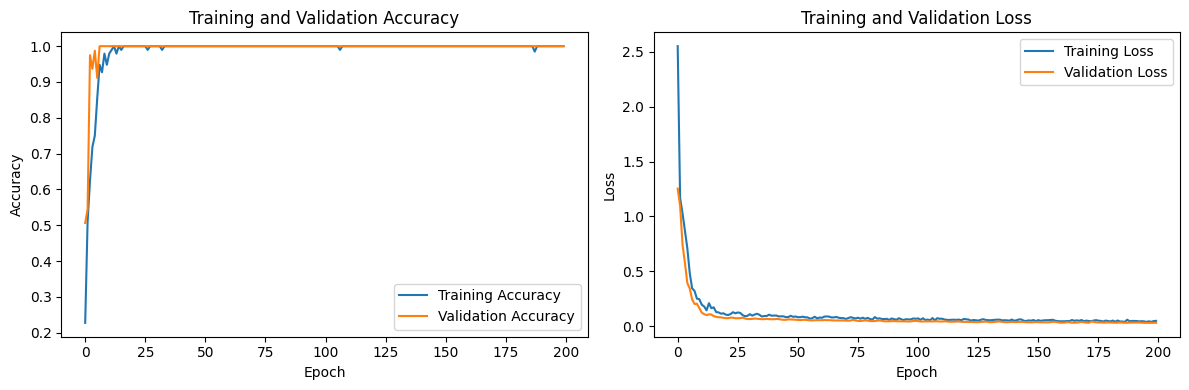

In [4]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

6/6 [==============================] - 1s 140ms/step


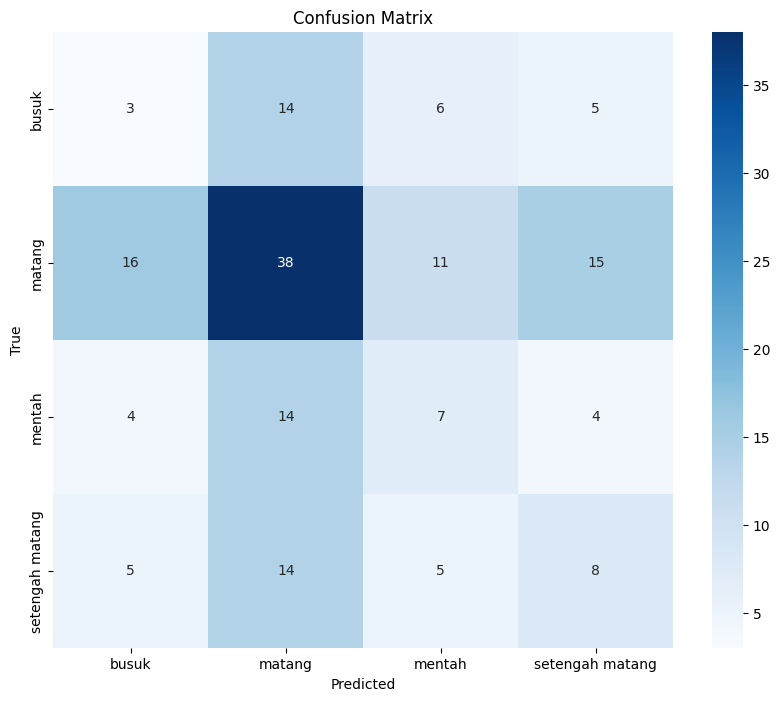

In [5]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [6]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [7]:
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)

# Generate and print classification report
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(class_report)

6/6 [==============================] - 0s 52ms/step
Confusion Matrix:
[[ 5 13  3  7]
 [10 41 15 14]
 [ 7 10  6  6]
 [ 6 16  5  5]]
Classification Report:
                 precision    recall  f1-score   support

          busuk       0.18      0.18      0.18        28
         matang       0.51      0.51      0.51        80
         mentah       0.21      0.21      0.21        29
setengah matang       0.16      0.16      0.16        32

       accuracy                           0.34       169
      macro avg       0.26      0.26      0.26       169
   weighted avg       0.34      0.34      0.34       169



In [8]:
# Save the Trained Model
model.save('trained_model.h5')
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp1thottoy\assets


INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp1thottoy\assets
